<a href="https://colab.research.google.com/github/PranavViswanathan/HVACAnomalyDetection/blob/main/HVAC_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data

The data obtained is from Kaggle. The data can be downloaded from [here](https://www.kaggle.com/datasets/shashwatwork/hvac-systems-anomaly-detection-using-ml?resource=download)

The dataset contains 11 variables:

1. timestamp;
2.temperatures of return, supply, and outdoor air [°C];
3. relative humidities of return, supply and outdoor air [% and outdoor air [%];
4. the temperature setpoint of the return air [°C];
5. the saturation temperature in the humidifier [°C];
6. power required by the fans [kW];
7. energy required by the fans [kWh].


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

In [3]:
data = "/content/drive/MyDrive/HVAC/HVAC_NE_EC_19-21.csv"
df = pd.read_csv(data)

In [4]:
df.head()

,Timestamp,T_Supply,T_Return,SP_Return,T_Saturation,T_Outdoor,RH_Supply,RH_Return,RH_Outdoor,Energy,Power
0,2019-10-15 00:00:00+02:00,19.859999,20.469999,18.5,19.02,20.299999,71.110001,58.919998,79.5,0.0,0.0
1,2019-10-15 00:15:00+02:00,19.855000,20.430000,18.5,19.02,20.299999,71.320000,59.000000,82.0,0.0,0.0
2,2019-10-15 00:30:00+02:00,19.850000,20.410000,18.5,19.02,20.299999,71.470001,59.109997,79.5,0.0,0.0
3,2019-10-15 00:45:00+02:00,19.840000,20.379999,18.5,19.08,20.299999,71.439995,59.309998,77.0,0.0,0.0
4,2019-10-15 01:00:00+02:00,19.830000,20.350000,18.5,19.08,20.299999,71.580002,59.559998,79.5,0.0,0.0


## Checking for null values in the dataset

In [5]:
df.isna().sum() 

Timestamp       0
T_Supply        0
T_Return        0
SP_Return       0
T_Saturation    0
T_Outdoor       0
RH_Supply       0
RH_Return       0
RH_Outdoor      0
Energy          0
Power           0
dtype: int64

## Understanding the types of data we have

In [6]:
df.info()
df['Timestamp'] = pd.to_datetime(df['Timestamp'], utc = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33888 entries, 0 to 33887
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Timestamp     33888 non-null  object 
 1   T_Supply      33888 non-null  float64
 2   T_Return      33888 non-null  float64
 3   SP_Return     33888 non-null  float64
 4   T_Saturation  33888 non-null  float64
 5   T_Outdoor     33888 non-null  float64
 6   RH_Supply     33888 non-null  float64
 7   RH_Return     33888 non-null  float64
 8   RH_Outdoor    33888 non-null  float64
 9   Energy        33888 non-null  float64
 10  Power         33888 non-null  float64
dtypes: float64(10), object(1)
memory usage: 2.8+ MB


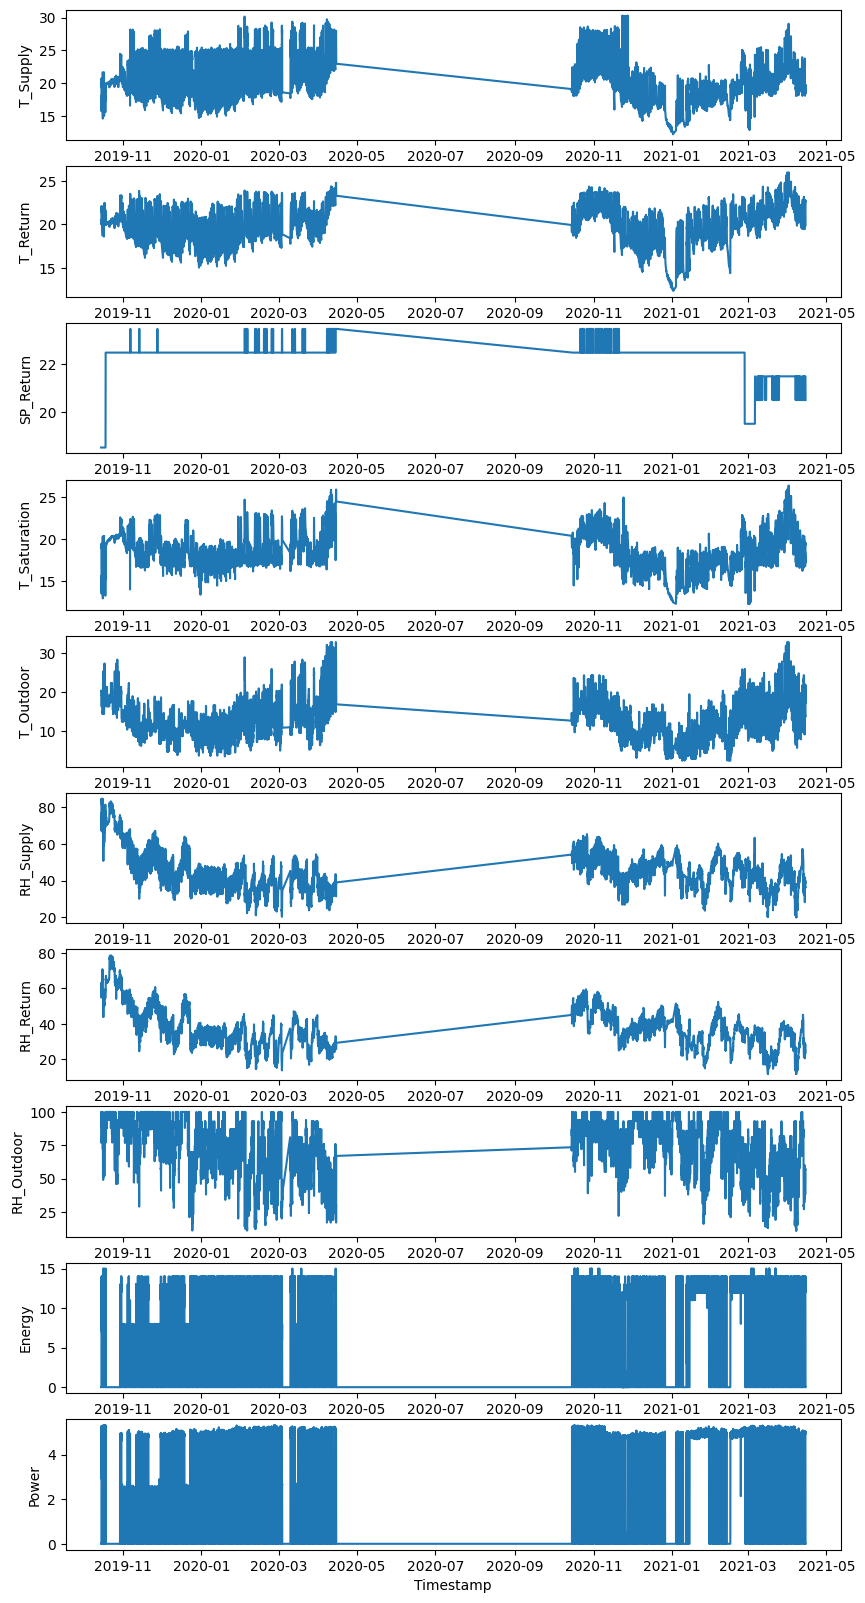

In [7]:
columns = df.columns.tolist()


fig, axs = plt.subplots(nrows=len(columns)-1, ncols=1, figsize=(10,20))

for i in range(len(columns)-1):
    axs[i].plot(df[columns[0]], df[columns[i+1]])
    axs[i].set_xlabel(columns[0])
    axs[i].set_ylabel(columns[i+1])

plt.show()

In [8]:
array = set(df['Timestamp'].dt.month)
array

{1, 2, 3, 4, 10, 11, 12}

As we can see, something happens with the data between the months of May to October. The set of data indicates that we do not have any data for the months 5,6,7,8,9 (ie) May, June, July, August, September

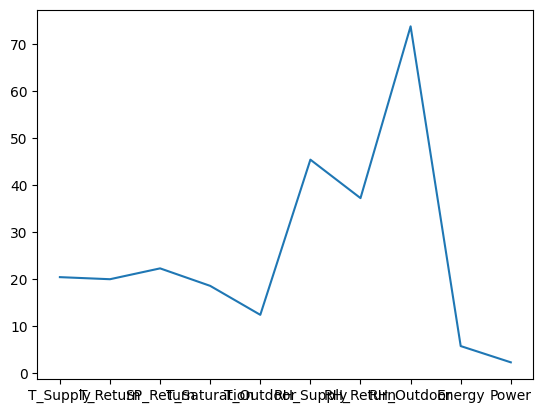

In [9]:
columnMeans = df.drop("Timestamp", axis = 1).mean()
plt.plot(columnMeans)

# Model Selection

The data we have is unlabeled and hence we need to use unsupervised classification methods for anomaly detection

The models we can try are:

1. K-means
2. K-medioid
3. DBSCAN
4. Agglomerative clustering


Now, we will try K-means and DBScan

## KMeans

In [10]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from scipy.spatial.distance import euclidean
import numpy as np

df2 = pd.DataFrame(df.drop("Timestamp", axis=1))
df2 = scale(df2)

kmeans = KMeans(n_clusters=3)
kmeans.fit(df2)

center = kmeans.cluster_centers_

distances = []
for i in range(df2.shape[0]):
    x = df2[i]
    centroid = center[kmeans.predict(x.reshape(1, -1))[0]]
    dist = euclidean(x, centroid)
    distances.append(dist)
    
threshold = np.percentile(distances, 95)

anomalies = np.where(np.array(distances) > threshold)[0]


print("Anomalous data points:", anomalies)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Anomalous data points: [    0     1     2 ... 33243 33244 33331]


Number of data entries :  33888  Anamalous entries:  1695


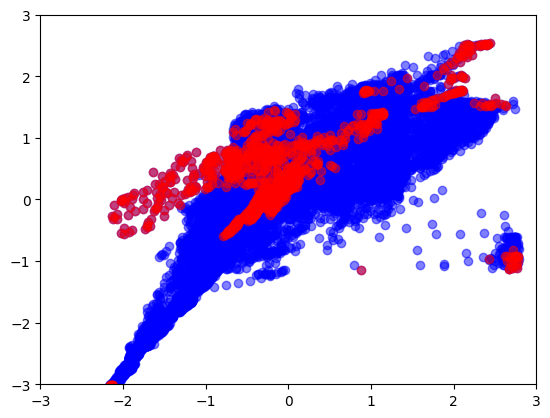

In [11]:
print("Number of data entries : ", df.shape[0], " Anamalous entries: ", len(anomalies))

plt.xlim(-3, 3)
plt.ylim(-3, 3)

df.shape
df2.shape
plt.scatter(df2[:, 0], df2[:, 1], c='blue', alpha=0.5)

# Plot the anomalies in red
plt.scatter(df2[anomalies, 0], df2[anomalies, 1], c='red', alpha=0.5)

## DBSCAN

In [12]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import scale
from scipy.spatial.distance import euclidean
import numpy as np

df2 = pd.DataFrame(df.drop("Timestamp", axis=1))
df2 = scale(df2)

dbscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
dbscan.fit(df2)

distances = []
for i in range(df2.shape[0]):
    x = df2[i]
    cluster_label = dbscan.labels_[i]
    cluster_center = np.mean(df2[dbscan.labels_ == cluster_label], axis=0)
    dist = euclidean(x, cluster_center)
    distances.append(dist)

threshold = np.percentile(distances, 95)

anomalies = np.where(np.array(distances) > threshold)[0]

print("Anomalous data points:", anomalies)


Anomalous data points: [   29    66    85 ... 33254 33297 33298]


Number of data entries :  33888  Anamalous entries:  1695


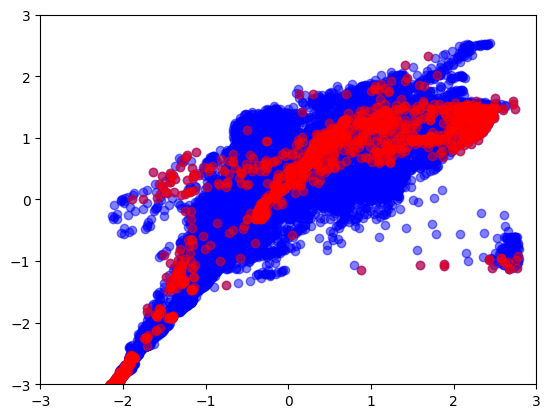

In [13]:
print("Number of data entries : ", df.shape[0], " Anamalous entries: ", len(anomalies))

plt.xlim(-3, 3)
plt.ylim(-3, 3)

df.shape
df2.shape
plt.scatter(df2[:, 0], df2[:, 1], c='blue', alpha=0.5)

# Plot the anomalies in red
plt.scatter(df2[anomalies, 0], df2[anomalies, 1], c='red', alpha=0.5)